In [1]:
from PIL import Image
import pytesseract
from pathlib import Path
import os.path
from os import path

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Path('C:/Program Files\ Tesseract-OCR\ tesseract').as_posix()
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

In [5]:
# Simple image to string
print(pytesseract.image_to_string(Image.open('guy_with_letters.png')))
print(pytesseract.image_to_string(Image.open('image_text_2.jfif')))
print(pytesseract.image_to_boxes(Image.open('image_text_2.jfif')))



Every morning
is special and
you will not get
them again. Sle,
: a"

  

“~ Good morning my
dear friend!
E 8 164 16 183 0
v 14 165 23 173 0
e 21 160 29 183 0
r 22 160 45 173 0
y 36 160 44 183 0
m 49 165 68 173 0
o 59 160 67 176 0
r 66 160 74 176 0
n 74 160 82 176 0
i 68 160 104 176 0
n 89 160 97 176 0
g 96 160 104 176 0
i 14 140 17 151 0
s 18 140 24 148 0
s 29 135 33 153 0
p 32 135 39 153 0
e 38 135 47 153 0
c 27 135 66 151 0
i 52 135 59 153 0
a 58 135 64 153 0
l 68 140 98 153 0
a 78 130 84 164 0
n 83 130 90 164 0
d 89 130 101 164 0
y 0 105 10 134 0
o 4 111 25 124 0
u 16 105 25 134 0
w 31 115 43 124 0
i 38 105 44 134 0
l 44 115 47 126 0
l 49 115 57 128 0
n 62 105 71 134 0
o 62 115 78 124 0
t 78 115 83 126 0
g 89 111 94 125 0
e 94 115 102 123 0
t 102 115 108 126 0
t 13 81 23 111 0
h 23 81 31 111 0
e 17 90 46 103 0
m 38 81 46 111 0
a 53 81 61 111 0
g 54 86 69 100 0
a 68 90 76 99 0
i 77 90 80 102 0
n 80 81 86 111 0
. 81 90 91 99 0
S 219 83 247 122 0
l 236 74 246 126 0
e 248 93 263 111 0


In [6]:
# Pre-processing to improve tesseract accuracy
import cv2
import numpy as np


# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [7]:
image = cv2.imread('image_text_2.jfif')
gray = get_grayscale(image)
print(pytesseract.image_to_string(gray))
thresh = thresholding(gray)
print(pytesseract.image_to_string(thresh)) # Seems to work best.
opening = opening(gray)
print(pytesseract.image_to_string(opening))
canny = canny(gray)
print(pytesseract.image_to_string(canny))

Every morning
is special and
you will not get
them again.

ge

 

Se.
Fay
Good morning my
dear friend!
Every morning
is special and
you will not get
them again.

pe

 

Se.
fay
Good morning my
dear Friend!
veel gt

(Ao an
a eae
occu) a
Peer ae
i
Demat 7 Sie.

oe ares
aL)
dear Friend


In [10]:
# Plot bounding boxes around each character

import cv2
import pytesseract

# Original image
image = cv2.imread('image_text_2.jfif')
# Image to find bounding boxes
gray = get_grayscale(image)
thresh = thresholding(gray)

h, w, c = image.shape
boxes = pytesseract.image_to_boxes(thresh) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2.imshow('img', image)
cv2.waitKey(0)
cv2.destroyAllWindows()





 

 

  

 

    

 

  

        

 
  

     
  

    
  

 
      

   
  

   



«SE
me
L
xy
=

‘CATEGORY
oe
CNTRIES
O1
Ce

asimrxe
2OMAY200/
A
8
&
7
®
090
K

ENTER
BEFORE
=
URATION
OF
EACH
STAY
|
oA

ggem
20:
se
th
OS
YH
ZA]

OO
ISSUED
AT



ISSUE
DATE



-_
=_
—_
=_
—_
-_—
o-
-_
=
-_
-_-
~
-
-
~-



 



  

 



—~eeecerenen
er
ere
WMe
ee
ees

8
se
:
So
i
oe

,
°
——a-
°
Ma
Qe
“
.
"
‘
me
™“

on
www
se
ry
.
--
°
:
ome
Ss

FULL
NAME
Si
TS
Nee
toe
tw
NS
~

°
.
>
.
oo
“s
Aa
ms
*
_
Se
Os

.
¢
SE
rete
ot
;
SD

-
_
t
-
a
oa
.
ou
tt
fe

-:
-_.
~
oe
_
-
.
-
~
o-
-
-
.
-
—
~~
~
on
—
~-_
—_
—_
=_
_>
a
—_—
=
us
se
a
.~

lee
.
wes

~s
|

“ws
WS



—_-
as
@
wm
wee
|=



HERR
Q2
PR
SR

-
BIRTH
DATE
PASSPORT
NO.



é

~—p
ws

-~
wm
we
weer
ese
|
-



UE



>
—_

~e

.
ewe.



 

 

 
 

  
 

 
 

 



    



  

 



ie!
wo
°
-

Lor
a
ee
>
»
sv
@
,
-
Oo
-
~
-
7
-
-*
-
“se
.
.
.
Pe
.
:
$

‘e
Ce.
om
¢
ee
:
.
,
°
~
..
.
.
.
.
-
’
.
.
*
me
ef
~e.
a
.o
“°
.
:
e
‘
,

-
.
Le
.
.
.
.
:
-
.
.
.
.


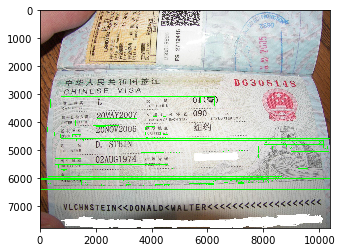

In [34]:
# Plot bounding box around words
from pytesseract import Output
import matplotlib.pyplot as plt
img = cv2.imread('2017_11534654.jpg')
img_big = cv2.resize(img, (0,0), fx=4, fy=4) 
img_pyplot = cv2.cvtColor(img_big, cv2.COLOR_BGR2RGB)

#cv2.imshow("im", cv2.resize(img, (960,540)))
#cv2.waitKey(0)
gray = get_grayscale(img_big)
blur_gray = cv2.medianBlur(gray, 3)
thresh = thresholding(blur_gray)

#cv2.imshow("im",cv2.resize(thresh, (960, 540)) )
#cv2.waitKey(0)
d = pytesseract.image_to_data(thresh, output_type=Output.DICT)
#print(d.keys())


def prepare_boxes(d, img):
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        print(d['text'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img
img_new = prepare_boxes(d, img_pyplot)

plt.imshow( img_new)

#d1 = pytesseract.image_to_data(img, output_type=Output.DICT)
#img_new = prepare_boxes(d1, img_pyplot)

#plt.imshow( img_new)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
cv2.imshow('img', gray)
cv2.waitKey(0)

In [12]:
d

{'level': [1,
  2,
  3,
  4,
  5,
  5,
  4,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  2,
  3,
  4,
  5,
  2,
  3,
  4,
  5,
  2,
  3,
  4,
  5,
  4,
  5,
  4,
  5,
  5,
  5,
  4,
  5,
  5],
 'page_num': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'block_num': [0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4],
 'par_num': [0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'line_num': [0,
  0,
  0,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  2,
  2,

In [2]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2

In [8]:
def decode_predictions(scores, geometry, min_confidence):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < min_confidence:
				continue
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [4]:
# round to the nearest multiple
def round_down(num, divisor):
    return num - (num%divisor)

In [5]:
# load the input image and grab the image dimensions
image = cv2.imread('2017_11534654.jpg')
orig = image.copy()
(origH, origW) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
#(newW, newH) = (2 * origW, 2*origH) #(args["width"], args["height"])
(newW, newH) = (origW, origH)
(newW, newH) = (round_down(newW, 32), round_down(newH, 32))
rW = origW / float(newW)
rH = origH / float(newH)
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [6]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

[INFO] loading EAST text detector...


In [36]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
min_conf = 0.05
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry, min_conf)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [37]:
print(boxes)

[[1151  949 1229  975]
 [1244  948 1319  974]
 [ 943  950 1091  975]
 [ 184 1096  277 1123]
 [ 308  970  431  996]
 [1622  942 1715  966]
 [ 944 1339 1094 1368]
 [ 275 1225  362 1250]
 [1531  942 1607  968]
 [ 940 1073 1091 1099]
 [ 189 1359  276 1384]
 [ 193  978  291 1003]
 [1733  938 1828  962]
 [ 942  826 1143  853]
 [ 187 1226  266 1251]
 [ 287 1358  365 1384]
 [ 289 1092  368 1120]
 [1100  952 1137  977]
 [ 197 1486  368 1511]
 [ 217  844  388  868]
 [1105 1341 1146 1372]
 [1049 1020 1088 1054]
 [1222  151 1260  312]
 [ 561 1276  866 1341]
 [1120  188 1158  276]
 [ 694  892  867  950]
 [ 707  609  777  656]
 [ 691  679  905  727]
 [ 624 1015  862 1075]
 [1367  877 1488  935]
 [ 281  687  588  733]
 [ 619 1144  822 1206]
 [ 255  803  359  833]
 [ 946  784  986  817]
 [1110 1290 1143 1325]
 [1992  616 2282  677]
 [1106  287 1156  445]
 [1365  763 1446  815]
 [ 494 1153  557 1210]
 [ 323 1705  750 1763]
 [ 774 1704 1213 1766]
 [1194 1701 1650 1761]
 [1737  597 2046  661]
 [ 997  602

In [42]:
# initialize the list of results

padding_value = 0.25
results = []
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * padding_value)
    dY = int((endY - startY) * padding_value)
    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 11")
    text = pytesseract.image_to_string(roi, config=config)
    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))

In [44]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
output = orig.copy()
# loop over the results
for ((startX, startY, endX, endY), text) in results:
	# display the text OCR'd by Tesseract
	print("OCR TEXT")
	print("========")
	print("{}\n".format(text))
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
	#output = orig.copy()
	cv2.rectangle(output, (startX, startY), (endX, endY),
		(0, 0, 255), 2)
	cv2.putText(output, text, (startX, startY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
	# show the output image
	#cv2.imshow("Text Detection", output)
	#cv2.waitKey(0)


OCR TEXT


OCR TEXT
=| [um] Laeec oe ge

OCR TEXT
ae

- >

S

* oO

g

>

OCR TEXT
22.00

OCR TEXT
N

OCR TEXT
N

we

OCR TEXT
ry

OCR TEXT
on

is

OCR TEXT


OCR TEXT
Ig

L Oo

~S

“oO

OCR TEXT
ty

ot

eves

ng

oeee

‘sewed

OCR TEXT
lo"

mio

OCR TEXT


OCR TEXT


OCR TEXT
B630813

OCR TEXT
eee

“ety

’

OCR TEXT
WE

OCR TEXT
FH |

OCR TEXT
YVSLAS

OCR TEXT
VISA

OCR TEXT
CHINESE V

OCR TEXT


OCR TEXT
01 ¢

OCR TEXT
Aa

iK

OCR TEXT
Ly

OCR TEXT
Ghee

OCR TEXT
ENTRIES

OCR TEXT
ATEGORY

OCR TEXT
ey OLS

090

OCR TEXT
OT” We ain) gt

\Y2007

OCR TEXT
ay

OCR TEXT
la

OCR TEXT
By AE

OCR TEXT


OCR TEXT
, ENTRY

OCR TEXT
> AFTER Eh

OCR TEXT
DAYS Al

OCR TEXT
| STAY

OCR TEXT
- EACH S

OCR TEXT
DURATION OF E

OCR TEXT
OF |

OCR TEXT
SSBEFORE

OCR TEXT
See eee

LZ)

OCR TEXT
ENTERS

OCR TEXT
a le I PO Pe eS or ee

NOV2006

#

OCR TEXT


OCR TEXT


OCR TEXT


OCR TEXT
ISSUED AT

OCR TEXT
: DATE

OCR TEXT
“ASSUE Dé

OCR TEXT
ee ee FF he ow hee

STEIN

OCR TEXT


OCR TEXT
_ NAME

OCR TE

NameError: name 'plt' is not defined

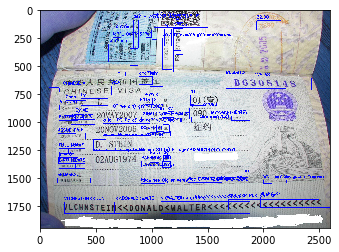

In [45]:
import matplotlib.pyplot as plt
plt.imshow(output)